<b><u>BENSARD ET AL, 2019 NOTEBOOK</u></b>   
Paper: Loss of the Mitochondrial Pyruvate Carrier Promotes Tumor Initiation  
Paper Author: Claire L. Bensard, et. al.   
Code by Jordan A. Berg and Alex J. Bott   
Description: The following notebook contains the code required to replicate specified plots and supplements

<b><u>IMPORT DEPENDENCIES</u></b> 

In [82]:
import os
import re
import pandas as pd 
import xpressplot as xp
from scipy import stats
from statsmodels.stats.multitest import multipletests
import GEOparse
%matplotlib inline

#Some microarray data was also processed using Alt Analyze (http://www.altanalyze.org/)

#Set path to this directory for accessing and saving files
__path__  = os.getcwd() + '/'

<b><u>SET FUNCTIONS</u></b> 

In [23]:
def get_geo(
    geo_id,
    output_info=False, output_path="./"):

    # Get data
    gse = GEOparse.get_GEO(geo=str(geo_id).upper(), destdir=output_path) # Import GSE dataset

    data = gse.pivot_samples('VALUE')
    data = xp.clean_df(data)

    # Get metadata
    # Write data to output file
    if output_info != False:
        with open(str(geo_id).upper() + '.txt', 'w+') as f: # Save all information as text file for reference
            for gsm_name, gsm in gse.gsms.items():
                f.write(gsm_name + '\n')
                for key, value in gsm.metadata.items():
                    f.write(" - %s : %s" % (key, ", ".join(value)) + '\n')

    # Populate metadata with sample ids and names
    metadata = pd.DataFrame(columns=['gsm', 'title']) # Create dataframe
    gsm_list, title_list, data_processing_list = [], [], []
    for gsm_name, gsm in gse.gsms.items():
        for key, value in gsm.metadata.items():
            if key == 'title':
                title_list.append(''.join(value))
            if key == 'geo_accession':
                gsm_list.append(''.join(value))
            if key == 'data_processing':
                data_processing_list.append(''.join(value))

    metadata['gsm'], metadata['title'] = gsm_list, title_list
    metadata.columns = range(metadata.shape[1])

    # Output processing style
    print('Data processing summary:\n' + str(set(data_processing_list))) # To determine if all samples have undergone the sample data processing

    # Clean data
    del data.columns.name
    del data.index.name

    # Clean metadata
    metadata[1] = metadata[1].apply(lambda x: x[0:(re.search("\d", x).start()) - 1])

    return data, metadata

<b><u>IMPORT HUMAN GSE8671 DATASET</u></b>   
The GEO-accessible data is not normalized. We therefore used Alt Analyze (http://www.altanalyze.org/) to RMA normalize probe signal.

In [15]:
#Get data
df_GSE8671 = xp.get_df(__path__ + 'data/GSE8671_rma_normalized.csv', delimiter=',') #RMA normalized with Alt Analyze
info_GSE8671 = xp.get_info(__path__ + "data/sample_info_gse8671.csv", delimiter=',')
df_GSE8671_c = xp.keep_labels(df_GSE8671, info_GSE8671, label_list=['Normal','Adenoma'])
df_GSE8671_clean = xp.clean_df(df_GSE8671_c)

#Collapse multi-mapping probes
df_GSE8671_collapsed = xp.probe_collapse(df_GSE8671_clean, __path__ + "data/GPL570.txt")
df_GSE8671_collapsed.to_csv(__path__ + "data/collapsed_GSE8671.csv",sep=',')

#Scale dataset
df_GSE8671_scaled, df_GSE8671_labeled = xp.prep_data(df_GSE8671_collapsed, info_GSE8671)

#sort by sample labels
info_GSE8671_sorted = info_GSE8671.copy()
info_GSE8671_sorted = info_GSE8671_sorted.loc[info_GSE8671_sorted[1].isin(['Adenoma', 'Normal'])]
info_GSE8671_sorted = info_GSE8671_sorted.sort_values([1], ascending=False)
info_GSE8671_sorted_list = info_GSE8671_sorted[0].tolist()
df_GSE8671_scaled_sorted = df_GSE8671_scaled[info_GSE8671_sorted_list]

#set palette
gse8671_colors = {'Adenoma': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
        'Normal': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

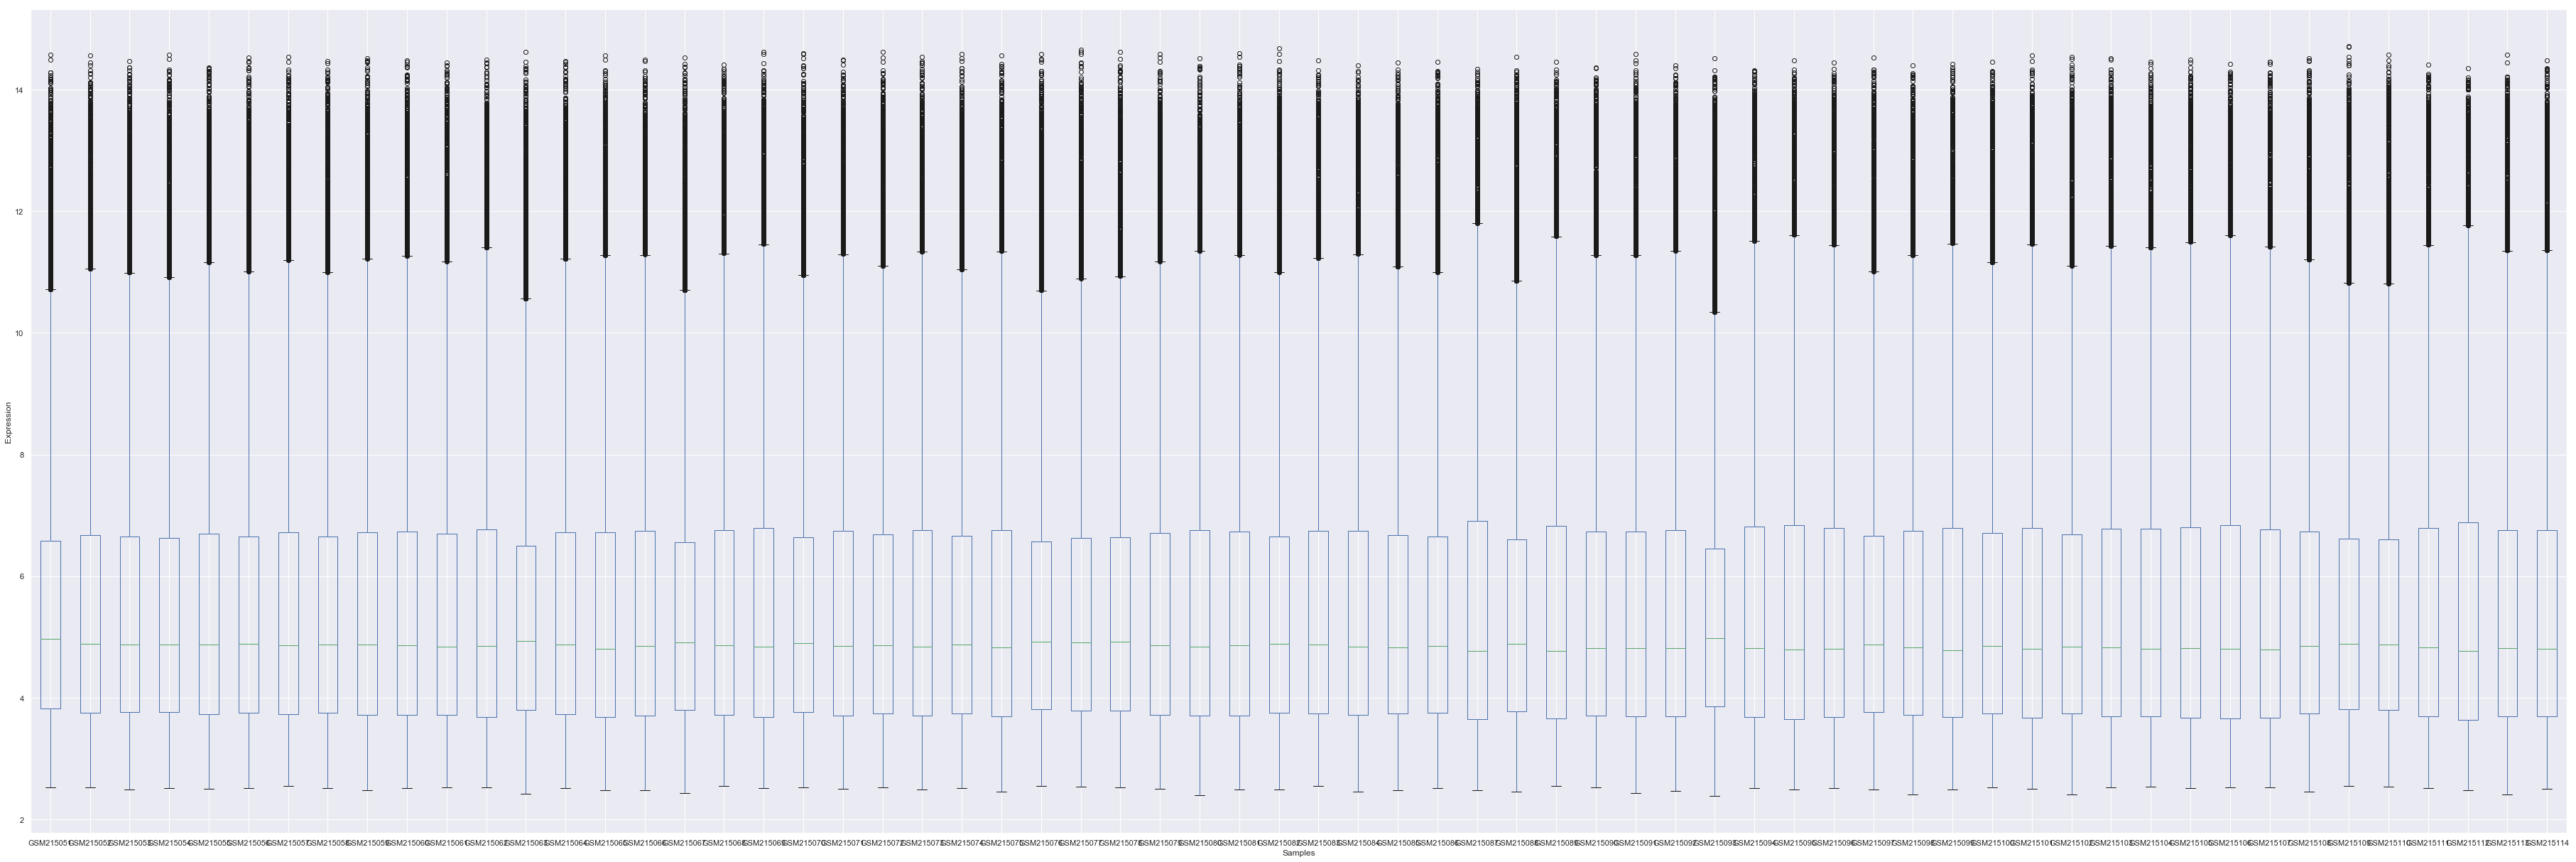

In [28]:
xp.check_samples(df_GSE8671_clean)

<b><u>IMPORT HUMAN GSE20916 DATASET</u></b> 

In [26]:
#Get data
df_GSE20916, info_GSE20916 = get_geo('GSE20916')
info_GSE20916[1] = info_GSE20916[1].str.capitalize() #Make sample types look nice
info_GSE20916 = info_GSE20916.replace('Normal_colon', 'Normal')
df_GSE20916_c = xp.keep_labels(df_GSE20916, info_GSE20916, label_list=['Normal','Adenoma','Adenocarcinoma'])
df_GSE20916_clean = xp.clean_df(df_GSE20916_c)

#Collapse multi-mapping probes
df_GSE20916_collapsed = xp.probe_collapse(df_GSE20916_clean, __path__ + "data/GPL570.txt")
df_GSE20916_collapsed.to_csv(__path__ + "data/collapsed_GSE20916.txt",sep='\t')

#Scale sorted dataset
df_GSE20916_scaled, df_GSE20916_labeled = xp.prep_data(df_GSE20916_collapsed, info_GSE20916)

#sort by sample labels
info_GSE20916_sorted = info_GSE20916.copy()
info_GSE20916_sorted = info_GSE20916_sorted.loc[info_GSE20916_sorted[1].isin(['Adenoma', 'Adenocarcinoma','Normal'])]
info_GSE20916_sorted = info_GSE20916_sorted.sort_values([1], ascending=False)
info_GSE20916_sorted_list = info_GSE20916_sorted[0].tolist()
df_GSE20916_scaled_sorted = df_GSE20916_scaled[info_GSE20916_sorted_list]

#Drop Adenocarcinomas
df_GSE20916_collapsed_noac = xp.drop_label(df_GSE20916_collapsed, info_GSE20916, 'Adenocarcinoma')

gse20916_colors = {'Adenocarcinoma': (0.5725490196078431, 0.5843137254901961, 0.5686274509803921),
        'Adenoma': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
        'Normal': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

23-Aug-2019 16:40:38 DEBUG utils - Directory ./ already exists. Skipping.
23-Aug-2019 16:40:38 INFO GEOparse - File already exist: using local version.
23-Aug-2019 16:40:38 INFO GEOparse - Parsing ./GSE20916_family.soft.gz: 
23-Aug-2019 16:40:38 DEBUG GEOparse - DATABASE: GeoMiame
23-Aug-2019 16:40:38 DEBUG GEOparse - SERIES: GSE20916
23-Aug-2019 16:40:38 DEBUG GEOparse - PLATFORM: GPL570
23-Aug-2019 16:40:39 DEBUG GEOparse - SAMPLE: GSM523242
23-Aug-2019 16:40:40 DEBUG GEOparse - SAMPLE: GSM523243
23-Aug-2019 16:40:40 DEBUG GEOparse - SAMPLE: GSM523244
23-Aug-2019 16:40:40 DEBUG GEOparse - SAMPLE: GSM523245
23-Aug-2019 16:40:40 DEBUG GEOparse - SAMPLE: GSM523246
23-Aug-2019 16:40:40 DEBUG GEOparse - SAMPLE: GSM523247
23-Aug-2019 16:40:40 DEBUG GEOparse - SAMPLE: GSM523248
23-Aug-2019 16:40:40 DEBUG GEOparse - SAMPLE: GSM523249
23-Aug-2019 16:40:40 DEBUG GEOparse - SAMPLE: GSM523250
23-Aug-2019 16:40:40 DEBUG GEOparse - SAMPLE: GSM523251
23-Aug-2019 16:40:40 DEBUG GEOparse - SAMPLE: GS

23-Aug-2019 16:40:47 DEBUG GEOparse - SAMPLE: GSM523382
23-Aug-2019 16:40:47 DEBUG GEOparse - SAMPLE: GSM523383
23-Aug-2019 16:40:47 DEBUG GEOparse - SAMPLE: GSM523384
23-Aug-2019 16:40:47 DEBUG GEOparse - SAMPLE: GSM523385
23-Aug-2019 16:40:47 DEBUG GEOparse - SAMPLE: GSM523386


Data processing summary:
{'Cell intensity files were generated using GCOS (Affymetrix). The probe set data was generated using R/BioConductor (version 2.8.1) packages affy (version 1.20.2), gcrma (version 2.14.1), and FLUSH.LVS.bundle (version 1.2.1, proportion=0.6). For data filtration, we selected the probe sets with signal intensity above the threshold limit in at least 5% of samples. The threshold was established at the 98th percentile of the expression levels from Y-chromosome–linked probe set signals detected detectable in female samples', 'Cell intensity files were generated using GCOS (Affymetrix). The probe set data was generated using R/BioConductor (version 2.8.1) packages affy (version 1.20.2), gcrma (version 2.14.1), and FLUSH.LVS.bundle (version 1.2.1, proportion=0.6). For data filtration, we selected the probe sets with signal intensity above the threshold limit in at least 5% of samples. The threshold was established at the 98th percentile of the expression levels from 

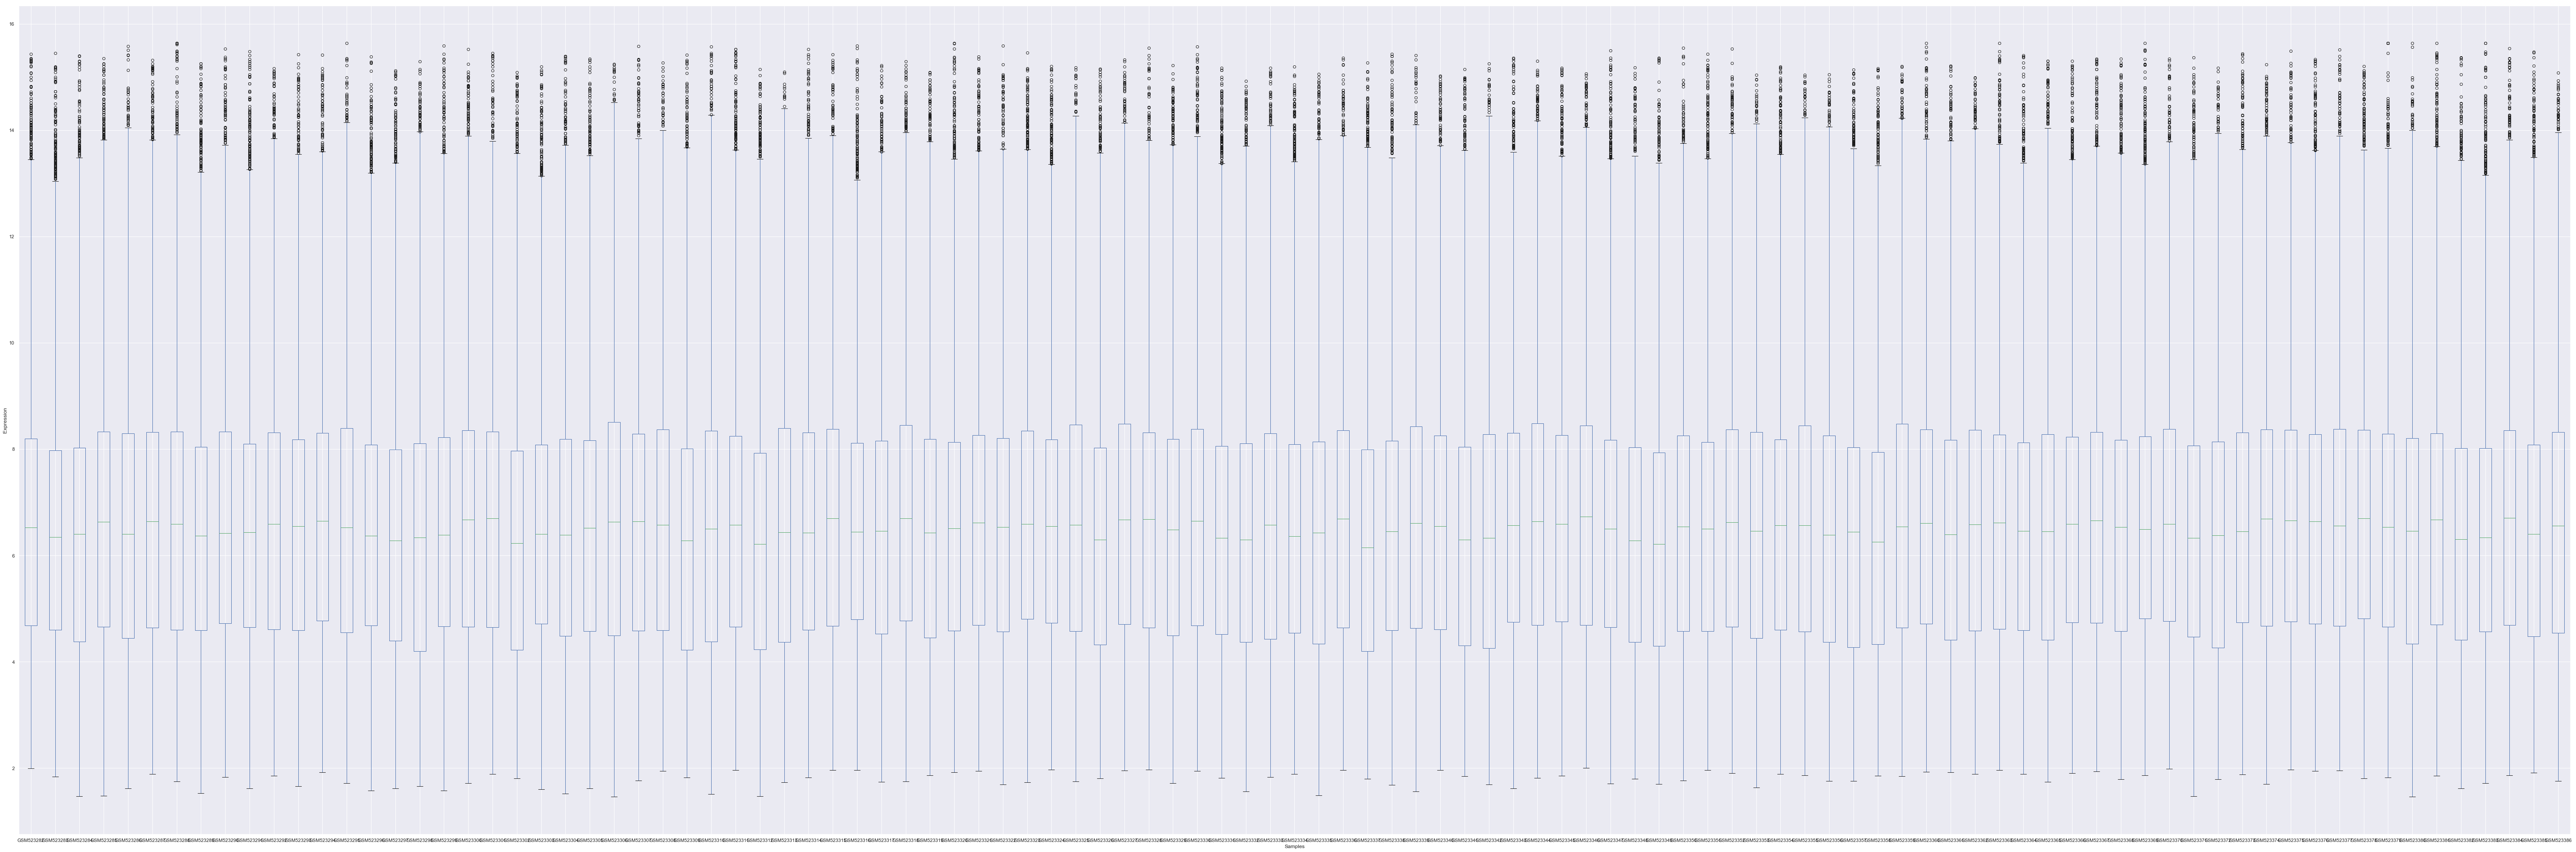

In [27]:
xp.check_samples(df_GSE20916_clean)

<b><u>IMPORT MOUSE APC DATASET</u></b> 

In [30]:
apc_df = pd.read_csv(__path__ + "data/custom_apc_normalized.csv", sep=",", index_col=0, low_memory=False)
apc_info = xp.get_info(__path__ + "data/apc_info.csv", delimiter=',')
apc_clean = xp.clean_df(apc_df)
apc_scaled, apc_labeled = xp.prep_data(apc_clean, apc_info)

apc_colors = {'APC-KO': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
         'APC-WT': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
         'Normal-KO': (0.8352941176470589, 0.3686274509803922, 0.0),
         'Normal-WT': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

<b><u>IMPORT MOUSE AOMDSS DATASET</u></b> 

In [31]:
aomdss_df = pd.read_csv(__path__ + "data/custom_aomdss_normalized.csv", sep=",", index_col=0, low_memory=False)
aomdss_info = xp.get_info(__path__ + "data/aomdss_info.csv", delimiter=',')
aomdss_clean = xp.clean_df(aomdss_df)
aomdss_scaled, aomdss_labeled = xp.prep_data(aomdss_clean, aomdss_info)

aomdss_colors = {'AOMDSS-KO': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
         'AOMDSS-WT': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
         'Normal-KO': (0.8352941176470589, 0.3686274509803922, 0.0),
         'Normal-WT': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

<b><u>GET GENE SETS</u></b> 

In [32]:
with open(__path__ + "data/custom22.csv", 'r') as f:
    for line in f:
        custom22_mouse = line.split(",")
custom22_human = [x.upper() for x in custom22_mouse]

stem_genes = ['Ctnnb1','Notch1','Ascl2','Myc','Hopx','Sox9','Lgr5','Lef1','Mmp7','Axin2','Cd44','Ccnd1','Bmi1','Tert']
diff_genes = ['Fabp2','Atoh1','Muc2','Krt20','Chga','Vil1','MPC1','MPC2']

pyru = pd.read_csv('data/custom_pyruvate_list.csv',header=None)
pyru_list = pyru[0].tolist()

In [33]:
print(len(pyru_list))
print(df_GSE8671_labeled.reindex(pyru_list).dropna().shape)
print(df_GSE20916_labeled.reindex(pyru_list).dropna().shape)

80
(75, 64)
(60, 105)


In [34]:
GSE8671_pyru = df_GSE8671_labeled.reindex(pyru_list)
GSE8671_pyru.to_csv('./data/GSE8671_pyruvate_list.csv')

In [35]:
GSE20916_pyru = df_GSE20916_labeled.reindex(pyru_list)
GSE20916_pyru.to_csv('./data/GSE20916_pyruvate_list.csv')

<b><u>FIGURE 1</u></b> 

<Figure size 432x288 with 0 Axes>

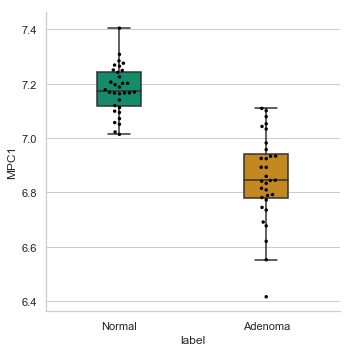

In [36]:
"""
LDH and MPC Relationship in Human Dataset GSE8671
"""
xp.gene_overview(df_GSE8671_labeled, info_GSE8671, gene_name='MPC1',palette=gse8671_colors, 
                  order=['Normal','Adenoma'], grid=True, whitegrid=True,
                 save_fig=__path__ + 'plots/MPC1_boxswarm_GSE8671.pdf')

<Figure size 432x288 with 0 Axes>

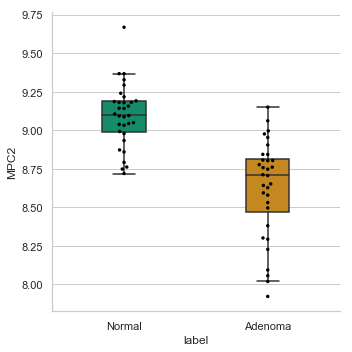

In [37]:
xp.gene_overview(df_GSE8671_labeled, info_GSE8671, gene_name='MPC2',palette=gse8671_colors, 
                  order=['Normal','Adenoma'],
                 save_fig=__path__ + 'plots/MPC2_boxswarm_GSE8671.pdf', grid=True, whitegrid=True)

<Figure size 432x288 with 0 Axes>

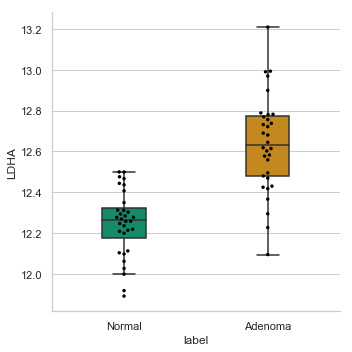

In [38]:
xp.gene_overview(df_GSE8671_labeled, info_GSE8671, gene_name='LDHA',palette=gse8671_colors, 
                  order=['Normal','Adenoma'],
                 save_fig=__path__ + 'plots/LDHA_boxswarm_GSE8671.pdf', grid=True, whitegrid=True)

<Figure size 432x288 with 0 Axes>

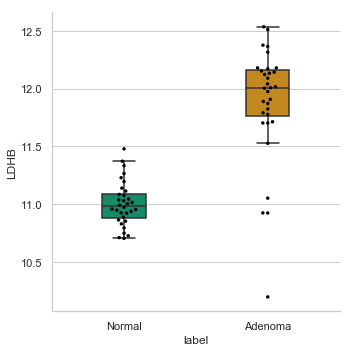

In [39]:
xp.gene_overview(df_GSE8671_labeled, info_GSE8671, gene_name='LDHB',palette=gse8671_colors, 
                  order=['Normal','Adenoma'],
                 save_fig=__path__ + 'plots/LDHB_boxswarm_GSE8671.pdf', grid=True, whitegrid=True)

In [45]:
df_GSE8671_labeled.head()

,GSM215051,GSM215052,GSM215053,GSM215054,GSM215055,GSM215056,GSM215057,GSM215058,GSM215059,GSM215060,...,GSM215105,GSM215106,GSM215107,GSM215108,GSM215109,GSM215110,GSM215111,GSM215112,GSM215113,GSM215114
label,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,...,Adenoma,Adenoma,Adenoma,Adenoma,Adenoma,Adenoma,Adenoma,Adenoma,Adenoma,Adenoma
A1BG,4.35319,3.96761,4.24751,3.85208,3.91906,4.43491,4.16286,4.06675,3.91035,4.08631,...,3.85096,3.91967,3.67355,3.88923,3.58279,3.48195,3.69009,3.79705,3.83171,4.08199
A1BG-AS1,4.8029,4.57598,4.78394,4.78304,4.78835,5.00612,4.41953,4.58723,4.46002,4.29711,...,4.66471,4.42415,4.34711,3.89743,4.47291,4.52202,4.29049,3.9907,4.42472,4.31857
A1CF,8.87268,8.6536,9.00399,8.82136,8.87924,8.15322,8.35725,8.5658,8.46511,8.30851,...,7.6014,8.16948,7.85755,7.81477,8.51393,6.39539,8.1324,7.97637,8.26149,7.49686
A2M,7.27749,7.1782,7.67233,7.5525,7.84766,7.86021,7.81956,7.84061,7.9375,7.49388,...,7.04161,7.16288,6.78937,6.89679,7.44922,6.27806,6.89239,6.94258,6.4923,7.02612


In [80]:
#Statistical tests
GSE8671_stats = df_GSE8671_labeled.copy()
GSE8671_norm = GSE8671_stats[info_GSE8671.loc[info_GSE8671[1] == 'Normal'][0].tolist()]
GSE8671_ad = GSE8671_stats[info_GSE8671.loc[info_GSE8671[1] == 'Adenoma'][0].tolist()]

p_vals = []
genes = GSE8671_stats.index.tolist()

total = len(genes) - 1
counter = 1

for x in genes[1:]:
    s, p = stats.ttest_ind(xp.get_array(GSE8671_norm, str(x)), xp.get_array(GSE8671_ad, str(x)))
    p_vals.append(p) 
    print(counter,'/',total)
    counter += 1

fdr = multipletests(p_vals, alpha=0.05, method='fdr_bh')

sig_data = pd.DataFrame()
sig_data[0] = p_vals 
sig_data[1] = fdr[1]
sig_data.index = genes[1:]

In [93]:
print('GSE8671')

#MPC1
print('MPC1: FDR=' + str(sig_data.loc['MPC1'][1]))

#MPC2
print('MPC2: FDR=' + str(sig_data.loc['MPC2'][1]))

#LDHA
print('LDHA: FDR=' + str(sig_data.loc['LDHA'][1]))

#LDHB
print('LDHB: FDR=' + str(sig_data.loc['LDHB'][1]))

GSE8671
MPC1: FDR=1.19280273417884e-13
MPC2: FDR=1.152046499105992e-08
LDHA: FDR=1.2073717946164597e-09
LDHB: FDR=3.3045373176185363e-12


<Figure size 432x288 with 0 Axes>

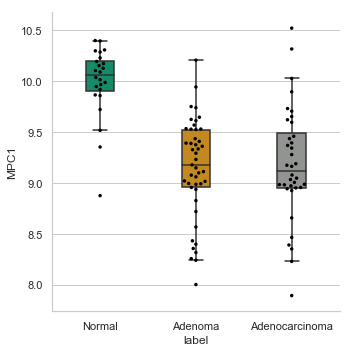

In [94]:
"""
LDH and MPC Relationship in Human Dataset GSE20916
"""
xp.gene_overview(df_GSE20916_labeled, info_GSE20916, gene_name='MPC1',palette=gse20916_colors, 
                  order=['Normal','Adenoma','Adenocarcinoma'],
                 save_fig=__path__ + 'plots/MPC1_boxswarm_GSE20916.pdf', grid=True, whitegrid=True)

<Figure size 432x288 with 0 Axes>

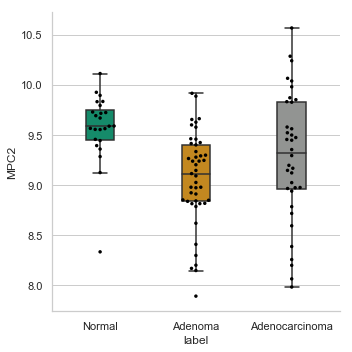

In [95]:
xp.gene_overview(df_GSE20916_labeled, info_GSE20916, gene_name='MPC2',palette=gse20916_colors, 
                  order=['Normal','Adenoma','Adenocarcinoma'],
                 save_fig=__path__ + 'plots/MPC2_boxswarm_GSE20916.pdf', grid=True, whitegrid=True)

<Figure size 432x288 with 0 Axes>

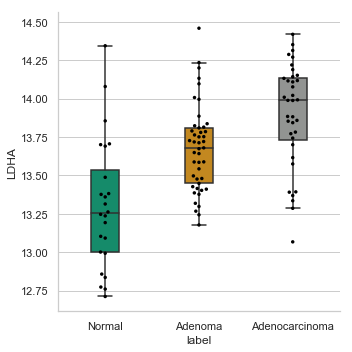

In [96]:
xp.gene_overview(df_GSE20916_labeled, info_GSE20916, gene_name='LDHA',palette=gse20916_colors, 
                  order=['Normal','Adenoma','Adenocarcinoma'],
                 save_fig=__path__ + 'plots/LDHA_boxswarm_GSE20916.pdf', grid=True, whitegrid=True)

<Figure size 432x288 with 0 Axes>

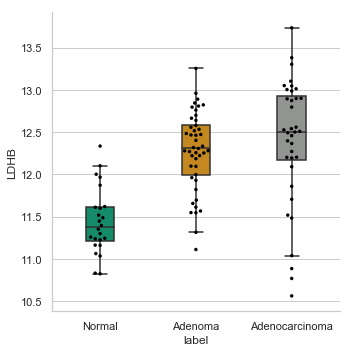

In [97]:
xp.gene_overview(df_GSE20916_labeled, info_GSE20916, gene_name='LDHB',palette=gse20916_colors, 
                  order=['Normal','Adenoma','Adenocarcinoma'],
                 save_fig=__path__ + 'plots/LDHB_boxswarm_GSE20916.pdf', grid=True, whitegrid=True)

In [98]:
#Statistical tests
GSE20916_stats = df_GSE20916_labeled.copy()
GSE20916_norm = GSE20916_stats[info_GSE20916.loc[info_GSE20916[1] == 'Normal'][0].tolist()]
GSE20916_ad = GSE20916_stats[info_GSE20916.loc[info_GSE20916[1] == 'Adenoma'][0].tolist()]

p_vals = []
genes = GSE20916_stats.index.tolist()

total = len(genes) - 1
counter = 1

for x in genes[1:]:
    s, p = stats.ttest_ind(xp.get_array(GSE20916_norm, str(x)), xp.get_array(GSE20916_ad, str(x)))
    p_vals.append(p) 
    print(counter,'/',total)
    counter += 1

fdr = multipletests(p_vals, alpha=0.05, method='fdr_bh')

sig_data = pd.DataFrame()
sig_data[0] = p_vals 
sig_data[1] = fdr[1]
sig_data.index = genes[1:]

1 / 11967
2 / 11967
3 / 11967
4 / 11967
5 / 11967
6 / 11967
7 / 11967
8 / 11967
9 / 11967
10 / 11967
11 / 11967
12 / 11967
13 / 11967
14 / 11967
15 / 11967
16 / 11967
17 / 11967
18 / 11967
19 / 11967
20 / 11967
21 / 11967
22 / 11967
23 / 11967
24 / 11967
25 / 11967
26 / 11967
27 / 11967
28 / 11967
29 / 11967
30 / 11967
31 / 11967
32 / 11967
33 / 11967
34 / 11967
35 / 11967
36 / 11967
37 / 11967
38 / 11967
39 / 11967
40 / 11967
41 / 11967
42 / 11967
43 / 11967
44 / 11967
45 / 11967
46 / 11967
47 / 11967
48 / 11967
49 / 11967
50 / 11967
51 / 11967
52 / 11967
53 / 11967
54 / 11967
55 / 11967
56 / 11967
57 / 11967
58 / 11967
59 / 11967
60 / 11967
61 / 11967
62 / 11967
63 / 11967
64 / 11967
65 / 11967
66 / 11967
67 / 11967
68 / 11967
69 / 11967
70 / 11967
71 / 11967
72 / 11967
73 / 11967
74 / 11967
75 / 11967
76 / 11967
77 / 11967
78 / 11967
79 / 11967
80 / 11967
81 / 11967
82 / 11967
83 / 11967
84 / 11967
85 / 11967
86 / 11967
87 / 11967
88 / 11967
89 / 11967
90 / 11967
91 / 11967
92 / 119

710 / 11967
711 / 11967
712 / 11967
713 / 11967
714 / 11967
715 / 11967
716 / 11967
717 / 11967
718 / 11967
719 / 11967
720 / 11967
721 / 11967
722 / 11967
723 / 11967
724 / 11967
725 / 11967
726 / 11967
727 / 11967
728 / 11967
729 / 11967
730 / 11967
731 / 11967
732 / 11967
733 / 11967
734 / 11967
735 / 11967
736 / 11967
737 / 11967
738 / 11967
739 / 11967
740 / 11967
741 / 11967
742 / 11967
743 / 11967
744 / 11967
745 / 11967
746 / 11967
747 / 11967
748 / 11967
749 / 11967
750 / 11967
751 / 11967
752 / 11967
753 / 11967
754 / 11967
755 / 11967
756 / 11967
757 / 11967
758 / 11967
759 / 11967
760 / 11967
761 / 11967
762 / 11967
763 / 11967
764 / 11967
765 / 11967
766 / 11967
767 / 11967
768 / 11967
769 / 11967
770 / 11967
771 / 11967
772 / 11967
773 / 11967
774 / 11967
775 / 11967
776 / 11967
777 / 11967
778 / 11967
779 / 11967
780 / 11967
781 / 11967
782 / 11967
783 / 11967
784 / 11967
785 / 11967
786 / 11967
787 / 11967
788 / 11967
789 / 11967
790 / 11967
791 / 11967
792 / 11967
793 

1383 / 11967
1384 / 11967
1385 / 11967
1386 / 11967
1387 / 11967
1388 / 11967
1389 / 11967
1390 / 11967
1391 / 11967
1392 / 11967
1393 / 11967
1394 / 11967
1395 / 11967
1396 / 11967
1397 / 11967
1398 / 11967
1399 / 11967
1400 / 11967
1401 / 11967
1402 / 11967
1403 / 11967
1404 / 11967
1405 / 11967
1406 / 11967
1407 / 11967
1408 / 11967
1409 / 11967
1410 / 11967
1411 / 11967
1412 / 11967
1413 / 11967
1414 / 11967
1415 / 11967
1416 / 11967
1417 / 11967
1418 / 11967
1419 / 11967
1420 / 11967
1421 / 11967
1422 / 11967
1423 / 11967
1424 / 11967
1425 / 11967
1426 / 11967
1427 / 11967
1428 / 11967
1429 / 11967
1430 / 11967
1431 / 11967
1432 / 11967
1433 / 11967
1434 / 11967
1435 / 11967
1436 / 11967
1437 / 11967
1438 / 11967
1439 / 11967
1440 / 11967
1441 / 11967
1442 / 11967
1443 / 11967
1444 / 11967
1445 / 11967
1446 / 11967
1447 / 11967
1448 / 11967
1449 / 11967
1450 / 11967
1451 / 11967
1452 / 11967
1453 / 11967
1454 / 11967
1455 / 11967
1456 / 11967
1457 / 11967
1458 / 11967
1459 / 11967

2020 / 11967
2021 / 11967
2022 / 11967
2023 / 11967
2024 / 11967
2025 / 11967
2026 / 11967
2027 / 11967
2028 / 11967
2029 / 11967
2030 / 11967
2031 / 11967
2032 / 11967
2033 / 11967
2034 / 11967
2035 / 11967
2036 / 11967
2037 / 11967
2038 / 11967
2039 / 11967
2040 / 11967
2041 / 11967
2042 / 11967
2043 / 11967
2044 / 11967
2045 / 11967
2046 / 11967
2047 / 11967
2048 / 11967
2049 / 11967
2050 / 11967
2051 / 11967
2052 / 11967
2053 / 11967
2054 / 11967
2055 / 11967
2056 / 11967
2057 / 11967
2058 / 11967
2059 / 11967
2060 / 11967
2061 / 11967
2062 / 11967
2063 / 11967
2064 / 11967
2065 / 11967
2066 / 11967
2067 / 11967
2068 / 11967
2069 / 11967
2070 / 11967
2071 / 11967
2072 / 11967
2073 / 11967
2074 / 11967
2075 / 11967
2076 / 11967
2077 / 11967
2078 / 11967
2079 / 11967
2080 / 11967
2081 / 11967
2082 / 11967
2083 / 11967
2084 / 11967
2085 / 11967
2086 / 11967
2087 / 11967
2088 / 11967
2089 / 11967
2090 / 11967
2091 / 11967
2092 / 11967
2093 / 11967
2094 / 11967
2095 / 11967
2096 / 11967

2654 / 11967
2655 / 11967
2656 / 11967
2657 / 11967
2658 / 11967
2659 / 11967
2660 / 11967
2661 / 11967
2662 / 11967
2663 / 11967
2664 / 11967
2665 / 11967
2666 / 11967
2667 / 11967
2668 / 11967
2669 / 11967
2670 / 11967
2671 / 11967
2672 / 11967
2673 / 11967
2674 / 11967
2675 / 11967
2676 / 11967
2677 / 11967
2678 / 11967
2679 / 11967
2680 / 11967
2681 / 11967
2682 / 11967
2683 / 11967
2684 / 11967
2685 / 11967
2686 / 11967
2687 / 11967
2688 / 11967
2689 / 11967
2690 / 11967
2691 / 11967
2692 / 11967
2693 / 11967
2694 / 11967
2695 / 11967
2696 / 11967
2697 / 11967
2698 / 11967
2699 / 11967
2700 / 11967
2701 / 11967
2702 / 11967
2703 / 11967
2704 / 11967
2705 / 11967
2706 / 11967
2707 / 11967
2708 / 11967
2709 / 11967
2710 / 11967
2711 / 11967
2712 / 11967
2713 / 11967
2714 / 11967
2715 / 11967
2716 / 11967
2717 / 11967
2718 / 11967
2719 / 11967
2720 / 11967
2721 / 11967
2722 / 11967
2723 / 11967
2724 / 11967
2725 / 11967
2726 / 11967
2727 / 11967
2728 / 11967
2729 / 11967
2730 / 11967

3289 / 11967
3290 / 11967
3291 / 11967
3292 / 11967
3293 / 11967
3294 / 11967
3295 / 11967
3296 / 11967
3297 / 11967
3298 / 11967
3299 / 11967
3300 / 11967
3301 / 11967
3302 / 11967
3303 / 11967
3304 / 11967
3305 / 11967
3306 / 11967
3307 / 11967
3308 / 11967
3309 / 11967
3310 / 11967
3311 / 11967
3312 / 11967
3313 / 11967
3314 / 11967
3315 / 11967
3316 / 11967
3317 / 11967
3318 / 11967
3319 / 11967
3320 / 11967
3321 / 11967
3322 / 11967
3323 / 11967
3324 / 11967
3325 / 11967
3326 / 11967
3327 / 11967
3328 / 11967
3329 / 11967
3330 / 11967
3331 / 11967
3332 / 11967
3333 / 11967
3334 / 11967
3335 / 11967
3336 / 11967
3337 / 11967
3338 / 11967
3339 / 11967
3340 / 11967
3341 / 11967
3342 / 11967
3343 / 11967
3344 / 11967
3345 / 11967
3346 / 11967
3347 / 11967
3348 / 11967
3349 / 11967
3350 / 11967
3351 / 11967
3352 / 11967
3353 / 11967
3354 / 11967
3355 / 11967
3356 / 11967
3357 / 11967
3358 / 11967
3359 / 11967
3360 / 11967
3361 / 11967
3362 / 11967
3363 / 11967
3364 / 11967
3365 / 11967

3925 / 11967
3926 / 11967
3927 / 11967
3928 / 11967
3929 / 11967
3930 / 11967
3931 / 11967
3932 / 11967
3933 / 11967
3934 / 11967
3935 / 11967
3936 / 11967
3937 / 11967
3938 / 11967
3939 / 11967
3940 / 11967
3941 / 11967
3942 / 11967
3943 / 11967
3944 / 11967
3945 / 11967
3946 / 11967
3947 / 11967
3948 / 11967
3949 / 11967
3950 / 11967
3951 / 11967
3952 / 11967
3953 / 11967
3954 / 11967
3955 / 11967
3956 / 11967
3957 / 11967
3958 / 11967
3959 / 11967
3960 / 11967
3961 / 11967
3962 / 11967
3963 / 11967
3964 / 11967
3965 / 11967
3966 / 11967
3967 / 11967
3968 / 11967
3969 / 11967
3970 / 11967
3971 / 11967
3972 / 11967
3973 / 11967
3974 / 11967
3975 / 11967
3976 / 11967
3977 / 11967
3978 / 11967
3979 / 11967
3980 / 11967
3981 / 11967
3982 / 11967
3983 / 11967
3984 / 11967
3985 / 11967
3986 / 11967
3987 / 11967
3988 / 11967
3989 / 11967
3990 / 11967
3991 / 11967
3992 / 11967
3993 / 11967
3994 / 11967
3995 / 11967
3996 / 11967
3997 / 11967
3998 / 11967
3999 / 11967
4000 / 11967
4001 / 11967

4578 / 11967
4579 / 11967
4580 / 11967
4581 / 11967
4582 / 11967
4583 / 11967
4584 / 11967
4585 / 11967
4586 / 11967
4587 / 11967
4588 / 11967
4589 / 11967
4590 / 11967
4591 / 11967
4592 / 11967
4593 / 11967
4594 / 11967
4595 / 11967
4596 / 11967
4597 / 11967
4598 / 11967
4599 / 11967
4600 / 11967
4601 / 11967
4602 / 11967
4603 / 11967
4604 / 11967
4605 / 11967
4606 / 11967
4607 / 11967
4608 / 11967
4609 / 11967
4610 / 11967
4611 / 11967
4612 / 11967
4613 / 11967
4614 / 11967
4615 / 11967
4616 / 11967
4617 / 11967
4618 / 11967
4619 / 11967
4620 / 11967
4621 / 11967
4622 / 11967
4623 / 11967
4624 / 11967
4625 / 11967
4626 / 11967
4627 / 11967
4628 / 11967
4629 / 11967
4630 / 11967
4631 / 11967
4632 / 11967
4633 / 11967
4634 / 11967
4635 / 11967
4636 / 11967
4637 / 11967
4638 / 11967
4639 / 11967
4640 / 11967
4641 / 11967
4642 / 11967
4643 / 11967
4644 / 11967
4645 / 11967
4646 / 11967
4647 / 11967
4648 / 11967
4649 / 11967
4650 / 11967
4651 / 11967
4652 / 11967
4653 / 11967
4654 / 11967

5210 / 11967
5211 / 11967
5212 / 11967
5213 / 11967
5214 / 11967
5215 / 11967
5216 / 11967
5217 / 11967
5218 / 11967
5219 / 11967
5220 / 11967
5221 / 11967
5222 / 11967
5223 / 11967
5224 / 11967
5225 / 11967
5226 / 11967
5227 / 11967
5228 / 11967
5229 / 11967
5230 / 11967
5231 / 11967
5232 / 11967
5233 / 11967
5234 / 11967
5235 / 11967
5236 / 11967
5237 / 11967
5238 / 11967
5239 / 11967
5240 / 11967
5241 / 11967
5242 / 11967
5243 / 11967
5244 / 11967
5245 / 11967
5246 / 11967
5247 / 11967
5248 / 11967
5249 / 11967
5250 / 11967
5251 / 11967
5252 / 11967
5253 / 11967
5254 / 11967
5255 / 11967
5256 / 11967
5257 / 11967
5258 / 11967
5259 / 11967
5260 / 11967
5261 / 11967
5262 / 11967
5263 / 11967
5264 / 11967
5265 / 11967
5266 / 11967
5267 / 11967
5268 / 11967
5269 / 11967
5270 / 11967
5271 / 11967
5272 / 11967
5273 / 11967
5274 / 11967
5275 / 11967
5276 / 11967
5277 / 11967
5278 / 11967
5279 / 11967
5280 / 11967
5281 / 11967
5282 / 11967
5283 / 11967
5284 / 11967
5285 / 11967
5286 / 11967

5851 / 11967
5852 / 11967
5853 / 11967
5854 / 11967
5855 / 11967
5856 / 11967
5857 / 11967
5858 / 11967
5859 / 11967
5860 / 11967
5861 / 11967
5862 / 11967
5863 / 11967
5864 / 11967
5865 / 11967
5866 / 11967
5867 / 11967
5868 / 11967
5869 / 11967
5870 / 11967
5871 / 11967
5872 / 11967
5873 / 11967
5874 / 11967
5875 / 11967
5876 / 11967
5877 / 11967
5878 / 11967
5879 / 11967
5880 / 11967
5881 / 11967
5882 / 11967
5883 / 11967
5884 / 11967
5885 / 11967
5886 / 11967
5887 / 11967
5888 / 11967
5889 / 11967
5890 / 11967
5891 / 11967
5892 / 11967
5893 / 11967
5894 / 11967
5895 / 11967
5896 / 11967
5897 / 11967
5898 / 11967
5899 / 11967
5900 / 11967
5901 / 11967
5902 / 11967
5903 / 11967
5904 / 11967
5905 / 11967
5906 / 11967
5907 / 11967
5908 / 11967
5909 / 11967
5910 / 11967
5911 / 11967
5912 / 11967
5913 / 11967
5914 / 11967
5915 / 11967
5916 / 11967
5917 / 11967
5918 / 11967
5919 / 11967
5920 / 11967
5921 / 11967
5922 / 11967
5923 / 11967
5924 / 11967
5925 / 11967
5926 / 11967
5927 / 11967

6490 / 11967
6491 / 11967
6492 / 11967
6493 / 11967
6494 / 11967
6495 / 11967
6496 / 11967
6497 / 11967
6498 / 11967
6499 / 11967
6500 / 11967
6501 / 11967
6502 / 11967
6503 / 11967
6504 / 11967
6505 / 11967
6506 / 11967
6507 / 11967
6508 / 11967
6509 / 11967
6510 / 11967
6511 / 11967
6512 / 11967
6513 / 11967
6514 / 11967
6515 / 11967
6516 / 11967
6517 / 11967
6518 / 11967
6519 / 11967
6520 / 11967
6521 / 11967
6522 / 11967
6523 / 11967
6524 / 11967
6525 / 11967
6526 / 11967
6527 / 11967
6528 / 11967
6529 / 11967
6530 / 11967
6531 / 11967
6532 / 11967
6533 / 11967
6534 / 11967
6535 / 11967
6536 / 11967
6537 / 11967
6538 / 11967
6539 / 11967
6540 / 11967
6541 / 11967
6542 / 11967
6543 / 11967
6544 / 11967
6545 / 11967
6546 / 11967
6547 / 11967
6548 / 11967
6549 / 11967
6550 / 11967
6551 / 11967
6552 / 11967
6553 / 11967
6554 / 11967
6555 / 11967
6556 / 11967
6557 / 11967
6558 / 11967
6559 / 11967
6560 / 11967
6561 / 11967
6562 / 11967
6563 / 11967
6564 / 11967
6565 / 11967
6566 / 11967

7121 / 11967
7122 / 11967
7123 / 11967
7124 / 11967
7125 / 11967
7126 / 11967
7127 / 11967
7128 / 11967
7129 / 11967
7130 / 11967
7131 / 11967
7132 / 11967
7133 / 11967
7134 / 11967
7135 / 11967
7136 / 11967
7137 / 11967
7138 / 11967
7139 / 11967
7140 / 11967
7141 / 11967
7142 / 11967
7143 / 11967
7144 / 11967
7145 / 11967
7146 / 11967
7147 / 11967
7148 / 11967
7149 / 11967
7150 / 11967
7151 / 11967
7152 / 11967
7153 / 11967
7154 / 11967
7155 / 11967
7156 / 11967
7157 / 11967
7158 / 11967
7159 / 11967
7160 / 11967
7161 / 11967
7162 / 11967
7163 / 11967
7164 / 11967
7165 / 11967
7166 / 11967
7167 / 11967
7168 / 11967
7169 / 11967
7170 / 11967
7171 / 11967
7172 / 11967
7173 / 11967
7174 / 11967
7175 / 11967
7176 / 11967
7177 / 11967
7178 / 11967
7179 / 11967
7180 / 11967
7181 / 11967
7182 / 11967
7183 / 11967
7184 / 11967
7185 / 11967
7186 / 11967
7187 / 11967
7188 / 11967
7189 / 11967
7190 / 11967
7191 / 11967
7192 / 11967
7193 / 11967
7194 / 11967
7195 / 11967
7196 / 11967
7197 / 11967

7778 / 11967
7779 / 11967
7780 / 11967
7781 / 11967
7782 / 11967
7783 / 11967
7784 / 11967
7785 / 11967
7786 / 11967
7787 / 11967
7788 / 11967
7789 / 11967
7790 / 11967
7791 / 11967
7792 / 11967
7793 / 11967
7794 / 11967
7795 / 11967
7796 / 11967
7797 / 11967
7798 / 11967
7799 / 11967
7800 / 11967
7801 / 11967
7802 / 11967
7803 / 11967
7804 / 11967
7805 / 11967
7806 / 11967
7807 / 11967
7808 / 11967
7809 / 11967
7810 / 11967
7811 / 11967
7812 / 11967
7813 / 11967
7814 / 11967
7815 / 11967
7816 / 11967
7817 / 11967
7818 / 11967
7819 / 11967
7820 / 11967
7821 / 11967
7822 / 11967
7823 / 11967
7824 / 11967
7825 / 11967
7826 / 11967
7827 / 11967
7828 / 11967
7829 / 11967
7830 / 11967
7831 / 11967
7832 / 11967
7833 / 11967
7834 / 11967
7835 / 11967
7836 / 11967
7837 / 11967
7838 / 11967
7839 / 11967
7840 / 11967
7841 / 11967
7842 / 11967
7843 / 11967
7844 / 11967
7845 / 11967
7846 / 11967
7847 / 11967
7848 / 11967
7849 / 11967
7850 / 11967
7851 / 11967
7852 / 11967
7853 / 11967
7854 / 11967

8423 / 11967
8424 / 11967
8425 / 11967
8426 / 11967
8427 / 11967
8428 / 11967
8429 / 11967
8430 / 11967
8431 / 11967
8432 / 11967
8433 / 11967
8434 / 11967
8435 / 11967
8436 / 11967
8437 / 11967
8438 / 11967
8439 / 11967
8440 / 11967
8441 / 11967
8442 / 11967
8443 / 11967
8444 / 11967
8445 / 11967
8446 / 11967
8447 / 11967
8448 / 11967
8449 / 11967
8450 / 11967
8451 / 11967
8452 / 11967
8453 / 11967
8454 / 11967
8455 / 11967
8456 / 11967
8457 / 11967
8458 / 11967
8459 / 11967
8460 / 11967
8461 / 11967
8462 / 11967
8463 / 11967
8464 / 11967
8465 / 11967
8466 / 11967
8467 / 11967
8468 / 11967
8469 / 11967
8470 / 11967
8471 / 11967
8472 / 11967
8473 / 11967
8474 / 11967
8475 / 11967
8476 / 11967
8477 / 11967
8478 / 11967
8479 / 11967
8480 / 11967
8481 / 11967
8482 / 11967
8483 / 11967
8484 / 11967
8485 / 11967
8486 / 11967
8487 / 11967
8488 / 11967
8489 / 11967
8490 / 11967
8491 / 11967
8492 / 11967
8493 / 11967
8494 / 11967
8495 / 11967
8496 / 11967
8497 / 11967
8498 / 11967
8499 / 11967

9059 / 11967
9060 / 11967
9061 / 11967
9062 / 11967
9063 / 11967
9064 / 11967
9065 / 11967
9066 / 11967
9067 / 11967
9068 / 11967
9069 / 11967
9070 / 11967
9071 / 11967
9072 / 11967
9073 / 11967
9074 / 11967
9075 / 11967
9076 / 11967
9077 / 11967
9078 / 11967
9079 / 11967
9080 / 11967
9081 / 11967
9082 / 11967
9083 / 11967
9084 / 11967
9085 / 11967
9086 / 11967
9087 / 11967
9088 / 11967
9089 / 11967
9090 / 11967
9091 / 11967
9092 / 11967
9093 / 11967
9094 / 11967
9095 / 11967
9096 / 11967
9097 / 11967
9098 / 11967
9099 / 11967
9100 / 11967
9101 / 11967
9102 / 11967
9103 / 11967
9104 / 11967
9105 / 11967
9106 / 11967
9107 / 11967
9108 / 11967
9109 / 11967
9110 / 11967
9111 / 11967
9112 / 11967
9113 / 11967
9114 / 11967
9115 / 11967
9116 / 11967
9117 / 11967
9118 / 11967
9119 / 11967
9120 / 11967
9121 / 11967
9122 / 11967
9123 / 11967
9124 / 11967
9125 / 11967
9126 / 11967
9127 / 11967
9128 / 11967
9129 / 11967
9130 / 11967
9131 / 11967
9132 / 11967
9133 / 11967
9134 / 11967
9135 / 11967

9706 / 11967
9707 / 11967
9708 / 11967
9709 / 11967
9710 / 11967
9711 / 11967
9712 / 11967
9713 / 11967
9714 / 11967
9715 / 11967
9716 / 11967
9717 / 11967
9718 / 11967
9719 / 11967
9720 / 11967
9721 / 11967
9722 / 11967
9723 / 11967
9724 / 11967
9725 / 11967
9726 / 11967
9727 / 11967
9728 / 11967
9729 / 11967
9730 / 11967
9731 / 11967
9732 / 11967
9733 / 11967
9734 / 11967
9735 / 11967
9736 / 11967
9737 / 11967
9738 / 11967
9739 / 11967
9740 / 11967
9741 / 11967
9742 / 11967
9743 / 11967
9744 / 11967
9745 / 11967
9746 / 11967
9747 / 11967
9748 / 11967
9749 / 11967
9750 / 11967
9751 / 11967
9752 / 11967
9753 / 11967
9754 / 11967
9755 / 11967
9756 / 11967
9757 / 11967
9758 / 11967
9759 / 11967
9760 / 11967
9761 / 11967
9762 / 11967
9763 / 11967
9764 / 11967
9765 / 11967
9766 / 11967
9767 / 11967
9768 / 11967
9769 / 11967
9770 / 11967
9771 / 11967
9772 / 11967
9773 / 11967
9774 / 11967
9775 / 11967
9776 / 11967
9777 / 11967
9778 / 11967
9779 / 11967
9780 / 11967
9781 / 11967
9782 / 11967

10313 / 11967
10314 / 11967
10315 / 11967
10316 / 11967
10317 / 11967
10318 / 11967
10319 / 11967
10320 / 11967
10321 / 11967
10322 / 11967
10323 / 11967
10324 / 11967
10325 / 11967
10326 / 11967
10327 / 11967
10328 / 11967
10329 / 11967
10330 / 11967
10331 / 11967
10332 / 11967
10333 / 11967
10334 / 11967
10335 / 11967
10336 / 11967
10337 / 11967
10338 / 11967
10339 / 11967
10340 / 11967
10341 / 11967
10342 / 11967
10343 / 11967
10344 / 11967
10345 / 11967
10346 / 11967
10347 / 11967
10348 / 11967
10349 / 11967
10350 / 11967
10351 / 11967
10352 / 11967
10353 / 11967
10354 / 11967
10355 / 11967
10356 / 11967
10357 / 11967
10358 / 11967
10359 / 11967
10360 / 11967
10361 / 11967
10362 / 11967
10363 / 11967
10364 / 11967
10365 / 11967
10366 / 11967
10367 / 11967
10368 / 11967
10369 / 11967
10370 / 11967
10371 / 11967
10372 / 11967
10373 / 11967
10374 / 11967
10375 / 11967
10376 / 11967
10377 / 11967
10378 / 11967
10379 / 11967
10380 / 11967
10381 / 11967
10382 / 11967
10383 / 11967
10384 

10904 / 11967
10905 / 11967
10906 / 11967
10907 / 11967
10908 / 11967
10909 / 11967
10910 / 11967
10911 / 11967
10912 / 11967
10913 / 11967
10914 / 11967
10915 / 11967
10916 / 11967
10917 / 11967
10918 / 11967
10919 / 11967
10920 / 11967
10921 / 11967
10922 / 11967
10923 / 11967
10924 / 11967
10925 / 11967
10926 / 11967
10927 / 11967
10928 / 11967
10929 / 11967
10930 / 11967
10931 / 11967
10932 / 11967
10933 / 11967
10934 / 11967
10935 / 11967
10936 / 11967
10937 / 11967
10938 / 11967
10939 / 11967
10940 / 11967
10941 / 11967
10942 / 11967
10943 / 11967
10944 / 11967
10945 / 11967
10946 / 11967
10947 / 11967
10948 / 11967
10949 / 11967
10950 / 11967
10951 / 11967
10952 / 11967
10953 / 11967
10954 / 11967
10955 / 11967
10956 / 11967
10957 / 11967
10958 / 11967
10959 / 11967
10960 / 11967
10961 / 11967
10962 / 11967
10963 / 11967
10964 / 11967
10965 / 11967
10966 / 11967
10967 / 11967
10968 / 11967
10969 / 11967
10970 / 11967
10971 / 11967
10972 / 11967
10973 / 11967
10974 / 11967
10975 

11501 / 11967
11502 / 11967
11503 / 11967
11504 / 11967
11505 / 11967
11506 / 11967
11507 / 11967
11508 / 11967
11509 / 11967
11510 / 11967
11511 / 11967
11512 / 11967
11513 / 11967
11514 / 11967
11515 / 11967
11516 / 11967
11517 / 11967
11518 / 11967
11519 / 11967
11520 / 11967
11521 / 11967
11522 / 11967
11523 / 11967
11524 / 11967
11525 / 11967
11526 / 11967
11527 / 11967
11528 / 11967
11529 / 11967
11530 / 11967
11531 / 11967
11532 / 11967
11533 / 11967
11534 / 11967
11535 / 11967
11536 / 11967
11537 / 11967
11538 / 11967
11539 / 11967
11540 / 11967
11541 / 11967
11542 / 11967
11543 / 11967
11544 / 11967
11545 / 11967
11546 / 11967
11547 / 11967
11548 / 11967
11549 / 11967
11550 / 11967
11551 / 11967
11552 / 11967
11553 / 11967
11554 / 11967
11555 / 11967
11556 / 11967
11557 / 11967
11558 / 11967
11559 / 11967
11560 / 11967
11561 / 11967
11562 / 11967
11563 / 11967
11564 / 11967
11565 / 11967
11566 / 11967
11567 / 11967
11568 / 11967
11569 / 11967
11570 / 11967
11571 / 11967
11572 

In [99]:
print('GSE20916')

#MPC1
print('MPC1: FDR=' + str(sig_data.loc['MPC1'][1]))

#MPC2
print('MPC2: FDR=' + str(sig_data.loc['MPC2'][1]))

#LDHA
print('LDHA: FDR=' + str(sig_data.loc['LDHA'][1]))

#LDHB
print('LDHB: FDR=' + str(sig_data.loc['LDHB'][1]))

GSE20916
MPC1: FDR=1.5373186274621786e-09
MPC2: FDR=4.6313314966408364e-05
LDHA: FDR=0.00015861491574682595
LDHB: FDR=2.3486508502050606e-09


<b><u>FIGURE 1 SUPPLEMENT</u></b> 

<Figure size 432x288 with 0 Axes>

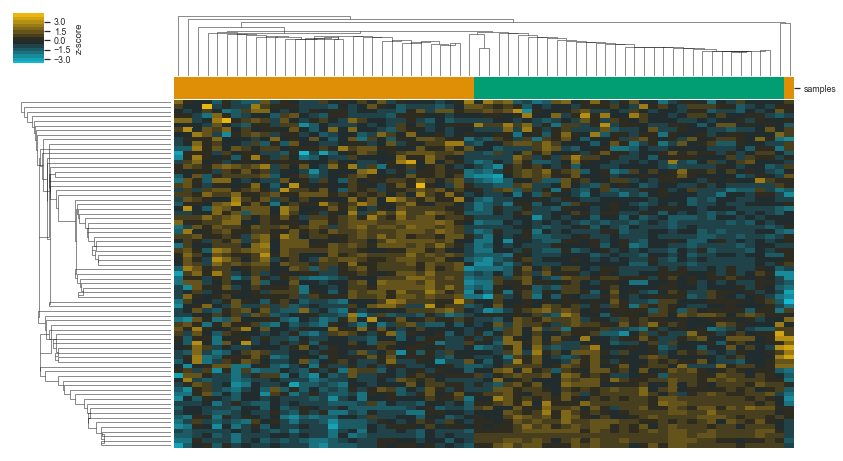

In [100]:
"""
Pyruvate-related Gene Expression Changes in Human Dataset GSE8671
"""
xp.heatmap(df_GSE8671_scaled_sorted, info_GSE8671, sample_palette=gse8671_colors, gene_list=pyru_list, 
            figsize=(14,8), save_fig=(__path__ + 'plots/GSE8671_customPyruvate_heatmap_colclustered.pdf'),
            row_cluster=True, col_cluster=True, yticklabels=False, xticklabels=False,
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

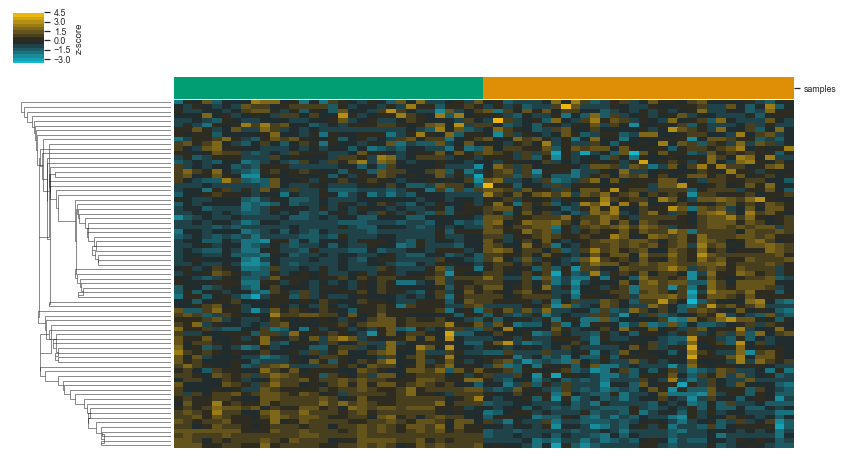

In [23]:
xp.heatmap(df_GSE8671_scaled_sorted, info_GSE8671, sample_palette=gse8671_colors, gene_list=pyru_list, 
            figsize=(14,8), save_fig=(__path__ + 'plots/GSE8671_customPyruvate_heatmap.pdf'),
            row_cluster=True, col_cluster=False, yticklabels=False, xticklabels=False,
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

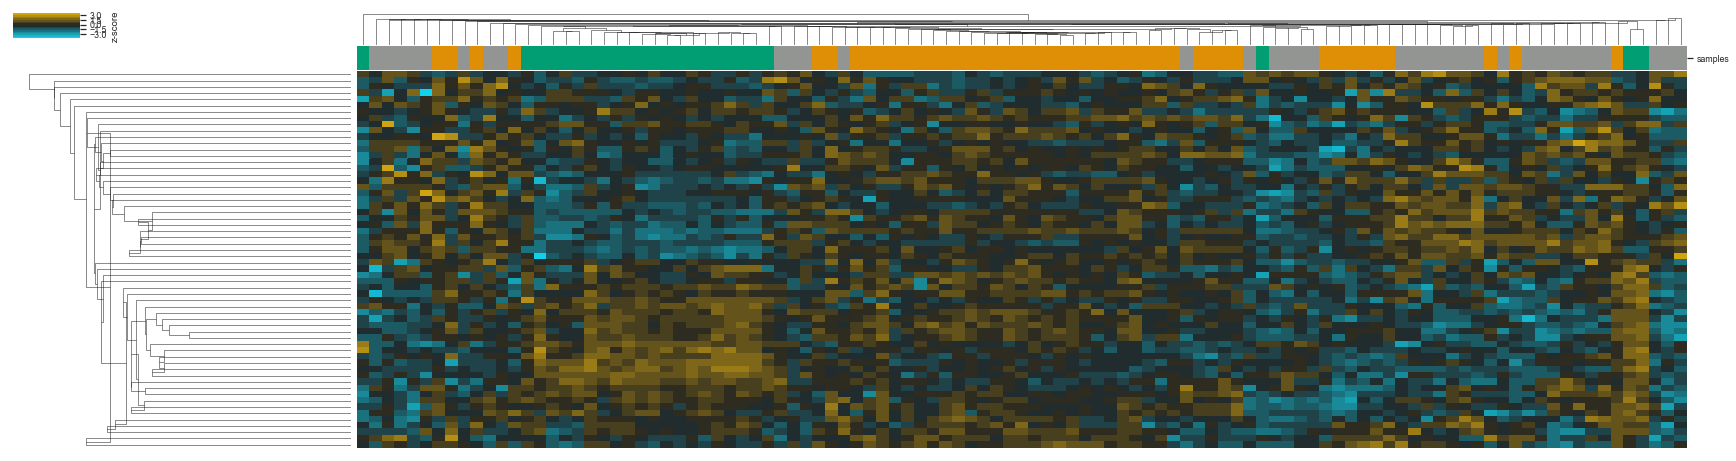

In [24]:
"""
Pyruvate-related Gene Expression Changes in Human Dataset GSE20916
"""
xp.heatmap(df_GSE20916_scaled_sorted, info_GSE20916, sample_palette=gse20916_colors, gene_list=pyru_list, 
            figsize=(30,8), save_fig=(__path__ + 'plots/GSE20916_customPyruvate_heatmap_colclustered.pdf'),
            row_cluster=True, col_cluster=True, yticklabels=False, xticklabels=False,
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

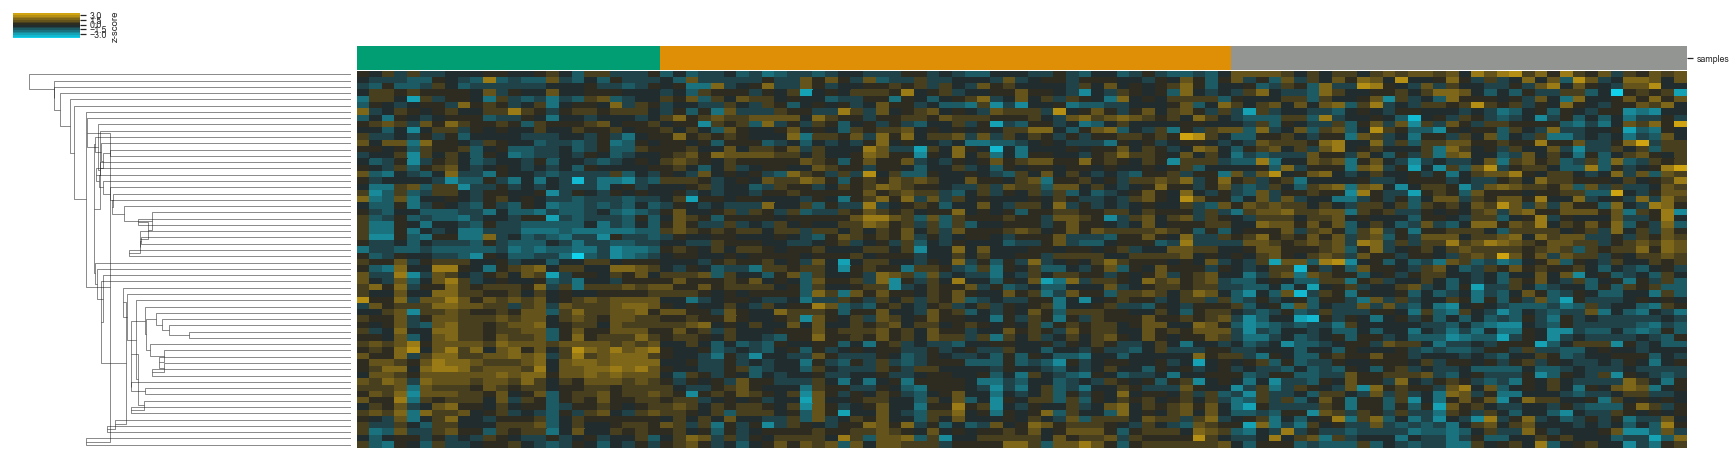

In [25]:
xp.heatmap(df_GSE20916_scaled_sorted, info_GSE20916, sample_palette=gse20916_colors, gene_list=pyru_list, 
            figsize=(30,8), save_fig=(__path__ + 'plots/GSE20916_customPyruvate_heatmap.pdf'),
            row_cluster=True, col_cluster=False, yticklabels=False, xticklabels=False,
            cbar_kws={'label': 'z-score'}, linewidths=0)

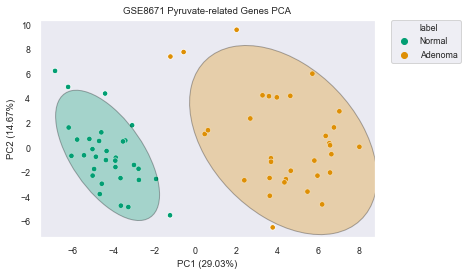

In [26]:
"""
Pyruvate-related Gene Expression Changes in Human Dataset GSE8671 -- PCA
"""
xp.pca(df_GSE8671_scaled, info_GSE8671, palette=gse8671_colors,
        gene_list=pyru_list,
       save_scree=__path__ + 'plots/GSE8671_pyru_list_PCA_scree.pdf',
       title='GSE8671 Pyruvate-related Genes PCA', 
        save_fig=__path__ + 'plots/GSE8671_pyru_list_2CI_PCA.pdf')

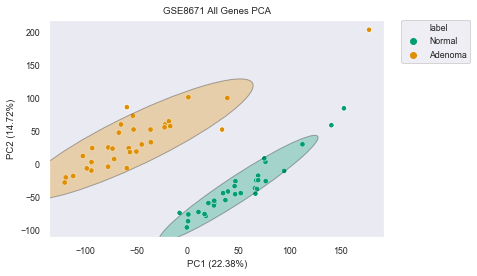

In [27]:
"""
Overall Gene Expression Changes in Human Dataset GSE8671 -- PCA
"""
xp.pca(df_GSE8671_scaled, info_GSE8671, palette=gse8671_colors,
       save_scree=__path__ + 'plots/GSE8671_all_genes_PCA_scree.pdf',
       title='GSE8671 All Genes PCA', 
        save_fig=__path__ + 'plots/GSE8671_all_genes_2CI_PCA.pdf')

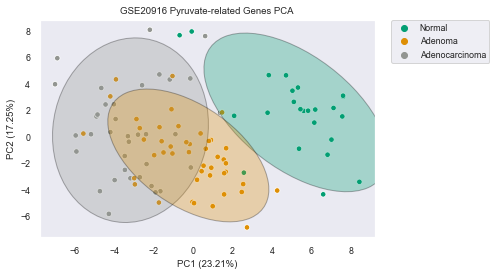

In [28]:
"""
Pyruvate-related Gene Expression Changes in Human Dataset GSE20916 -- PCA
"""
xp.pca(df_GSE20916_scaled, info_GSE20916, palette=gse20916_colors, order_legend=[1,3,2],
        gene_list=pyru_list,
       save_scree=__path__ + 'plots/GSE20916_pyru_list_PCA_scree.pdf',
       title='GSE20916 Pyruvate-related Genes PCA', 
        save_fig=__path__ + 'plots/GSE20916_pyru_list_2CI_PCA.pdf')

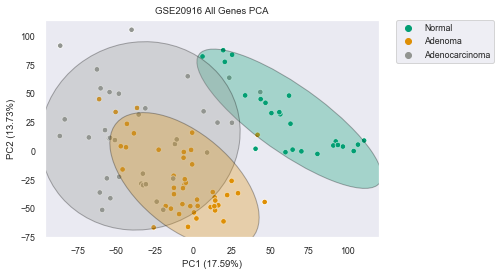

In [29]:
"""
Overall Gene Expression Changes in Human Dataset GSE20916 -- PCA
"""
xp.pca(df_GSE20916_scaled, info_GSE20916, palette=gse20916_colors, order_legend=[1,3,2],
       save_scree=__path__ + 'plots/GSE20916_all_genes_PCA_scree.pdf',
       title='GSE20916 All Genes PCA', 
        save_fig=__path__ + 'plots/GSE20916_all_genes_2CI_PCA.pdf')

<b><u>FIGURE 4</u></b> 

<Figure size 432x288 with 0 Axes>

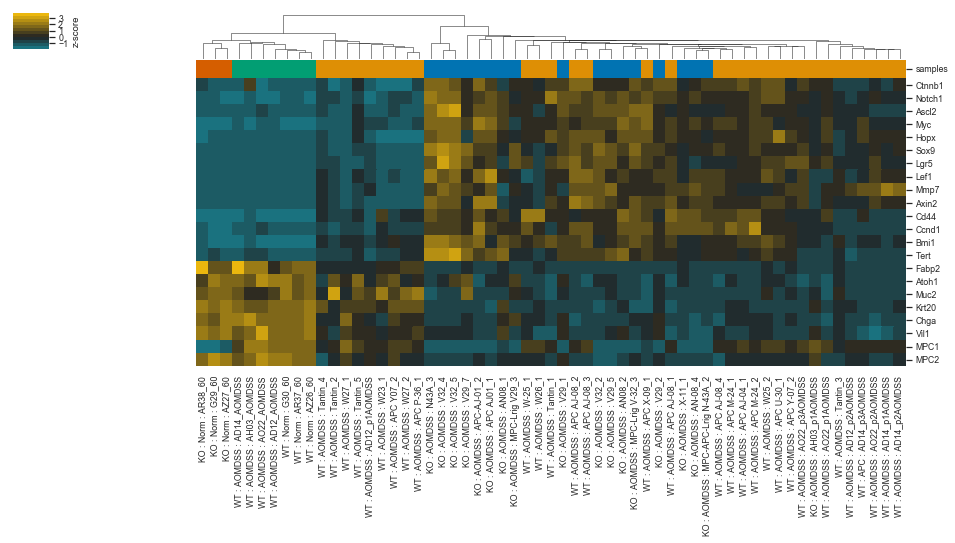

In [30]:
"""
Mouse AOMDSS Heatmap Custom22 Probes
"""
xp.heatmap(aomdss_scaled, aomdss_info, sample_palette=aomdss_colors, gene_list=custom22_mouse, 
            figsize=(16,6.5), save_fig=(__path__ + 'plots/AOMDSS_custom22_heatmap.pdf'), 
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

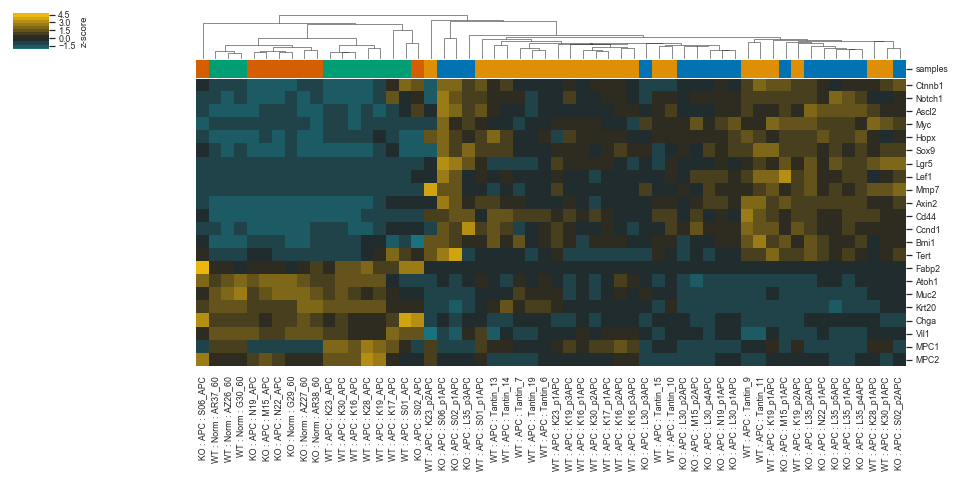

In [31]:
"""
Mouse APC Heatmap Custom22 Probes
"""
xp.heatmap(apc_scaled, apc_info, sample_palette=apc_colors, gene_list=custom22_mouse, 
            figsize=(16,6.5), save_fig=(__path__ + 'plots/APC_custom22_heatmap.pdf'), 
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

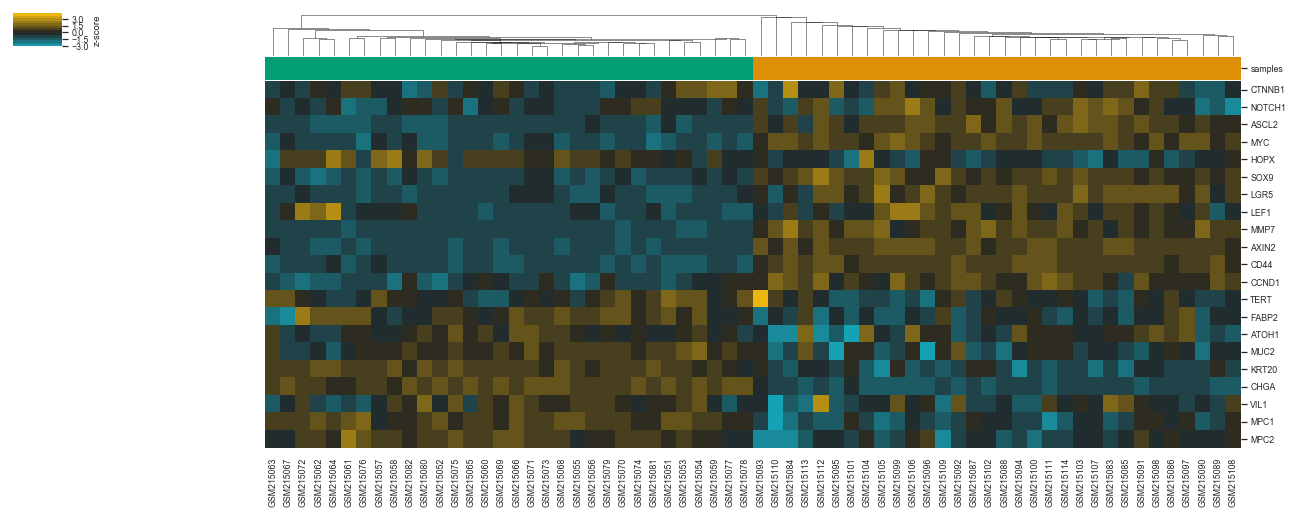

In [32]:
"""
Human GSE8671 Heatmap Custom22 Probes
"""
xp.heatmap(df_GSE8671_scaled, info_GSE8671, sample_palette=gse8671_colors, gene_list=custom22_human, 
            figsize=(22,8), save_fig=(__path__ + 'plots/GSE8671_custom22_heatmap.pdf'), 
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

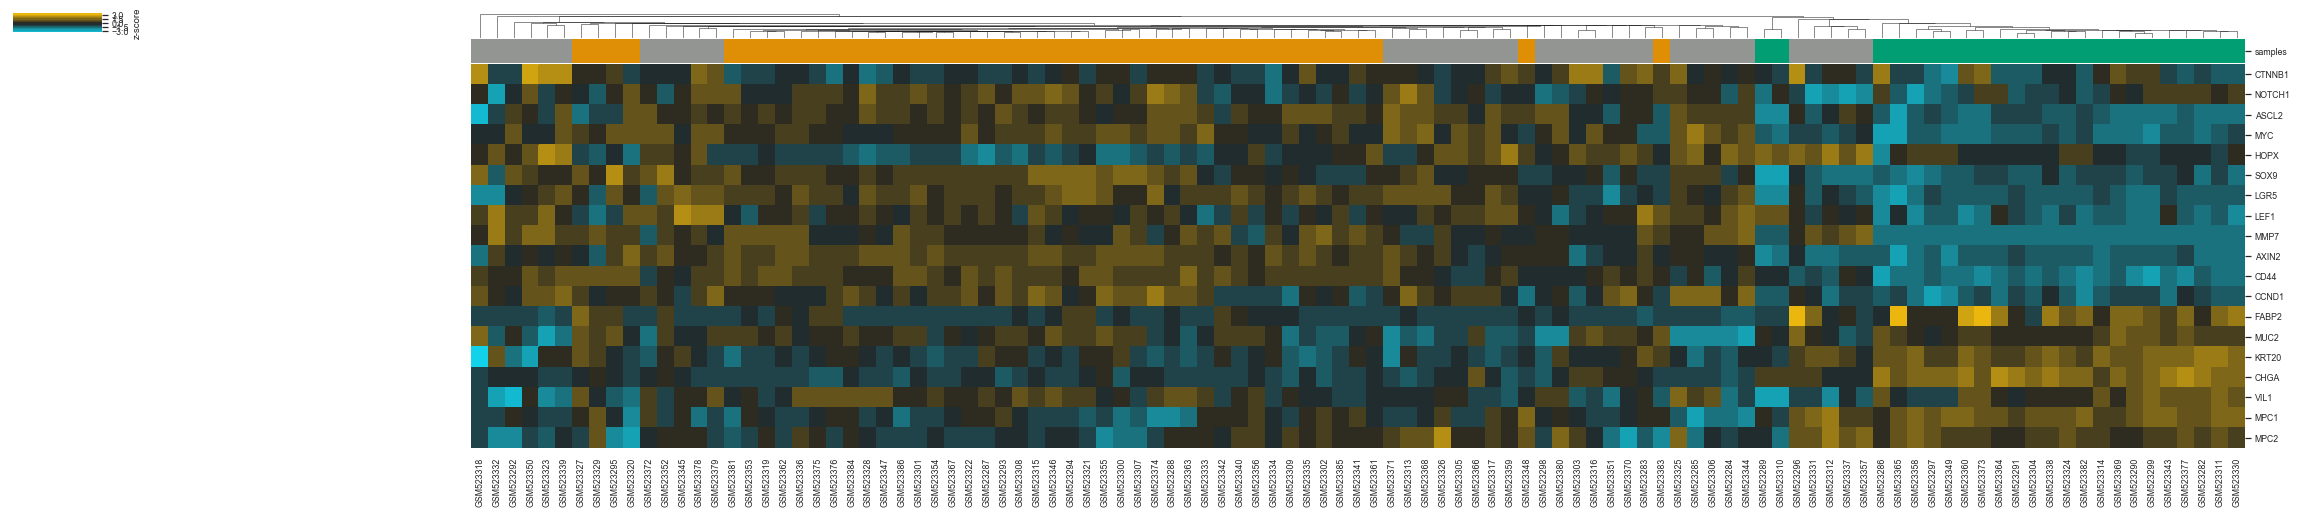

In [33]:
"""
Human GSE20916 Heatmap Custom22 Probes
"""
xp.heatmap(df_GSE20916_scaled, info_GSE20916, sample_palette=gse20916_colors, gene_list=custom22_human, 
            figsize=(40,8), save_fig=(__path__ + 'plots/GSE20916_custom22_heatmap.pdf'), 
            cbar_kws={'label': 'z-score'}, linewidths=0)

<b><u>FIGURE 4 SUPPLEMENT</u></b> 

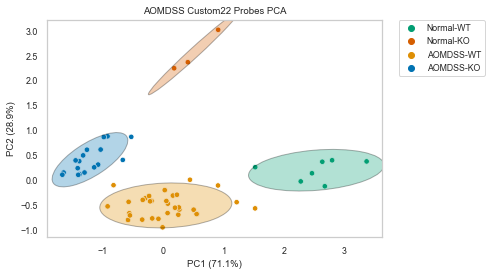

In [34]:
"""
Mouse AOMDSS Heatmap Custom22 Probes -- PCA
"""
xp.pca(aomdss_scaled, aomdss_info, palette=aomdss_colors, order_legend=[3,4,2,1], n_components=2,
        gene_list=custom22_human, whitegrid=True, grid=False,
       save_scree=__path__ + 'plots/AOMDSS_custom22_PCA_scree.pdf',
       title='AOMDSS Custom22 Probes PCA', 
        save_fig=__path__ + 'plots/AOMDSS_custom22_2CI_PCA.pdf')

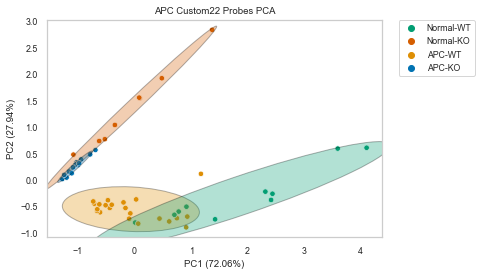

In [35]:
"""
Mouse APC Heatmap Custom22 Probes -- PCA
"""
xp.pca(apc_scaled, apc_info, palette=apc_colors, order_legend=[2,3,1,4], n_components=2,
        gene_list=custom22_human, whitegrid=True, grid=False,
       save_scree=__path__ + 'plots/APC_custom22_PCA_scree.pdf',
       title='APC Custom22 Probes PCA', 
        save_fig=__path__ + 'plots/APC_custom22_2CI_PCA.pdf')

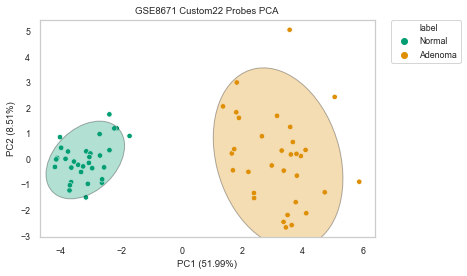

In [36]:
"""
Human GSE8671 Custom22 Probes -- PCA
"""
xp.pca(df_GSE8671_scaled, info_GSE8671, palette=gse8671_colors, n_components=2,
        gene_list=custom22_human, whitegrid=True, grid=False,
       save_scree=__path__ + 'plots/GSE8671_custom22_PCA_scree.pdf',
       title='GSE8671 Custom22 Probes PCA', 
        save_fig=__path__ + 'plots/GSE8671_custom22_2CI_PCA.pdf')

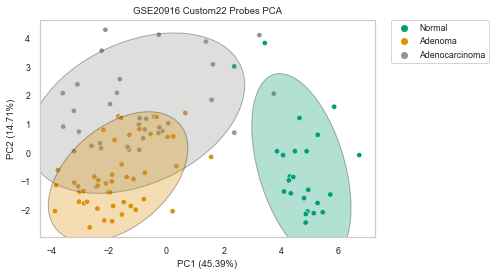

In [37]:
"""
Human GSE20916 Custom22 Probes -- PCA
"""
xp.pca(df_GSE20916_scaled, info_GSE20916, palette=gse20916_colors, order_legend=[1,3,2], n_components=2,
        gene_list=custom22_human, whitegrid=True, grid=False,
       save_scree=__path__ + 'plots/GSE20916_custom22_PCA_scree.pdf',
       title='GSE20916 Custom22 Probes PCA', 
        save_fig=__path__ + 'plots/GSE20916_custom22_2CI_PCA.pdf')

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



<Figure size 432x288 with 0 Axes>

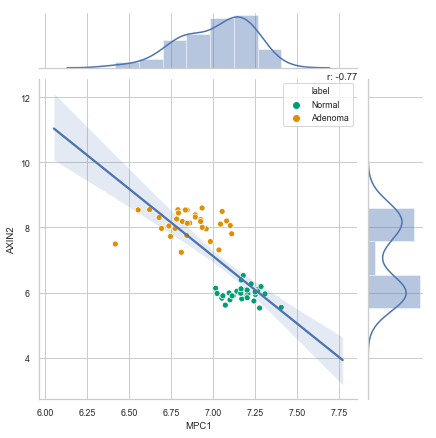

<Figure size 432x288 with 0 Axes>

In [38]:
"""
Human GSE8671 Jointplots -- MPC1 vs AXIN2
"""
xp.jointplot(df_GSE8671_collapsed, info_GSE8671, 'MPC1', 'AXIN2', palette=gse8671_colors, 
              order=['Normal','Adenoma'],
              save_fig=__path__ + 'plots/GSE8671_MPC1_AXIN2_jointplot.pdf', 
              dpi=600, bbox_inches='tight', whitegrid=True, grid=True)

<Figure size 432x288 with 0 Axes>

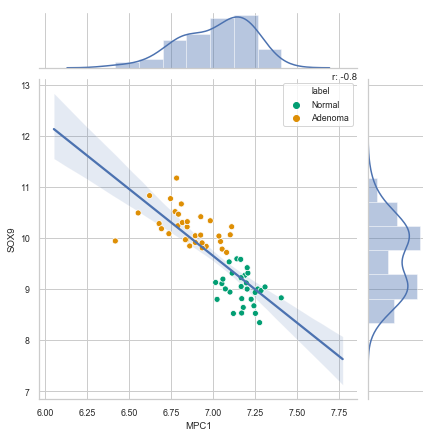

<Figure size 432x288 with 0 Axes>

In [39]:
"""
Human GSE8671 Jointplots -- MPC1 vs SOX9
"""
xp.jointplot(df_GSE8671_collapsed, info_GSE8671, 'MPC1', 'SOX9', palette=gse8671_colors, 
              order=['Normal','Adenoma'],
              save_fig=__path__ + 'plots/GSE8671_MPC1_SOX9_jointplot.pdf', 
              dpi=600, bbox_inches='tight', whitegrid=True, grid=True)

<Figure size 432x288 with 0 Axes>

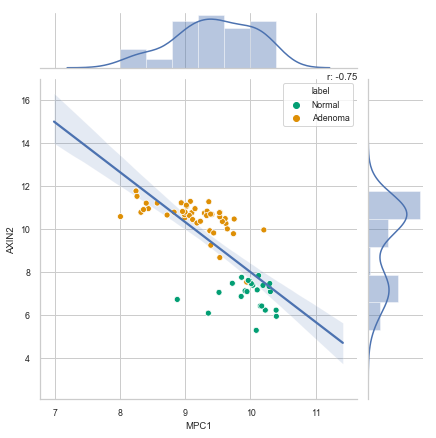

<Figure size 432x288 with 0 Axes>

In [40]:
"""
Human GSE20916 Jointplots -- MPC1 vs AXIN2, no adenocarcinomas
"""
xp.jointplot(df_GSE20916_collapsed_noac, info_GSE20916, 'MPC1', 'AXIN2', palette=gse20916_colors, 
              order=['Normal','Adenoma'],
              save_fig=__path__ + 'plots/GSE20916_MPC1_AXIN2_jointplot.pdf', 
              dpi=600, bbox_inches='tight', whitegrid=True, grid=True)

<Figure size 432x288 with 0 Axes>

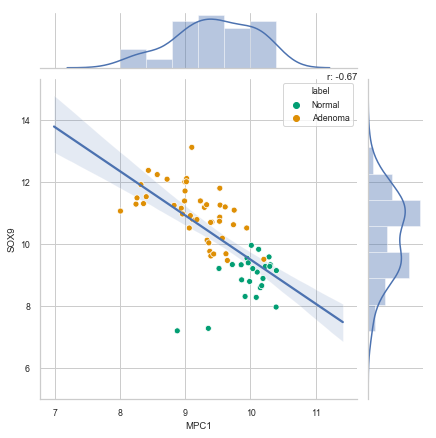

<Figure size 432x288 with 0 Axes>

In [41]:
"""
Human GSE20916 Jointplots -- MPC1 vs SOX9, no adenocarcinomas
"""
xp.jointplot(df_GSE20916_collapsed_noac, info_GSE20916, 'MPC1', 'SOX9', palette=gse20916_colors, 
              order=['Normal','Adenoma'],
              save_fig=__path__ + 'plots/GSE20916_MPC1_SOX9_jointplot.pdf', 
              dpi=600, bbox_inches='tight', whitegrid=True, grid=True)

<Figure size 432x288 with 0 Axes>

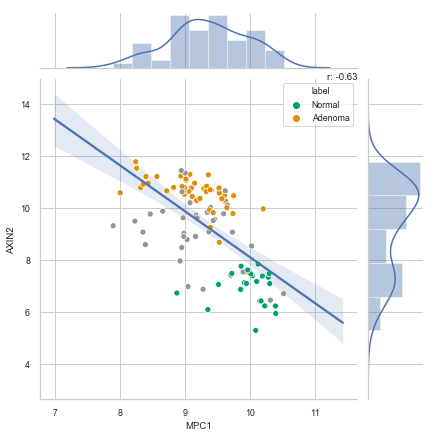

<Figure size 432x288 with 0 Axes>

In [42]:
"""
Human GSE20916 Jointplots -- MPC1 vs AXIN2
"""
xp.jointplot(df_GSE20916_collapsed, info_GSE20916, 'MPC1', 'AXIN2', palette=gse20916_colors, 
              order=['Normal','Adenoma'],
              save_fig=__path__ + 'plots/GSE20916_MPC1_AXIN2_jointplot.pdf', 
              dpi=600, bbox_inches='tight', whitegrid=True, grid=True)

<Figure size 432x288 with 0 Axes>

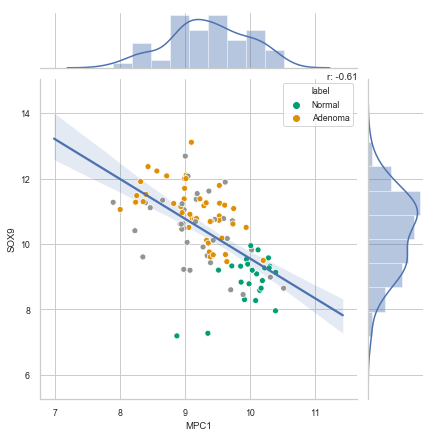

<Figure size 432x288 with 0 Axes>

In [43]:
"""
Human GSE20916 Jointplots -- MPC1 vs SOX9
"""
xp.jointplot(df_GSE20916_collapsed, info_GSE20916, 'MPC1', 'SOX9', palette=gse20916_colors, 
              order=['Normal','Adenoma'],
              save_fig=__path__ + 'plots/GSE20916_MPC1_SOX9_jointplot.pdf', 
              dpi=600, bbox_inches='tight', whitegrid=True, grid=True)

<b><u>FIGURE 4 CORRELATIONS</u></b> 

In [44]:
#GSE20916/MPC1/ALL
xp.linreg(df_GSE20916_collapsed, 'MPC1', __path__ + 'data/GSE20916_MPC1_ALL_correlations.csv')

#GSE20916/MPC2/ALL
xp.linreg(df_GSE20916_collapsed, 'MPC2', __path__ + 'data/GSE20916_MPC2_ALL_correlations.csv')

#GSE20916/MPC1/NoAdenocarcinoma
df_GSE20916_collapsed_noAC = xp.drop_label(df_GSE20916_collapsed, info_GSE20916, 'Adenocarcinoma')
xp.linreg(df_GSE20916_collapsed_noAC, 'MPC1', __path__ + 'data/GSE20916_MPC1_noAC_correlations.csv')

#GSE20916/MPC2/NoAdenocarcinoma
df_GSE20916_collapsed_noAC = xp.drop_label(df_GSE20916_collapsed, info_GSE20916, 'Adenocarcinoma')
xp.linreg(df_GSE20916_collapsed_noAC, 'MPC2', __path__ + 'data/GSE20916_MPC2_noAC_correlations.csv')

#GSE8671/MPC1/ALL
xp.linreg(df_GSE8671_collapsed, 'MPC1', __path__ + 'data/GSE8671_MPC1_ALL_correlations.csv')

#GSE8671/MPC2/ALL
xp.linreg(df_GSE8671_collapsed, 'MPC2', __path__ + 'data/GSE8671_MPC2_ALL_correlations.csv')